# AIPI 590 - XAI | In Class Adversarial Activity
### This is an in-class adversarial activity for AIPI 590 - XAI
##### Developed by Dr. Bent with assistance from Claude Haiku


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/adversarial-ai-example-notebooks/in_class_adversarial_activity.ipynb)

In [1]:
!pip install torch torchvision adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.4 MB/s eta 0:00:00


Run the following cell to set up the notebook and connect to the class GitHub repository with pre-trained models.

In [2]:
import os

!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Duke-AI-XAI"
git_path = 'https://github.com/AIPI-590-XAI/Duke-AI-XAI.git'
!git clone "{git_path}"

notebook_dir = 'adversarial-ai-example-notebooks'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

Cloning into 'Duke-AI-XAI'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 58 (delta 19), reused 43 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 6.39 MiB | 10.65 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/Duke-AI-XAI/adversarial-ai-example-notebooks
adversarial_attacks.ipynb  models/


### Import libraries

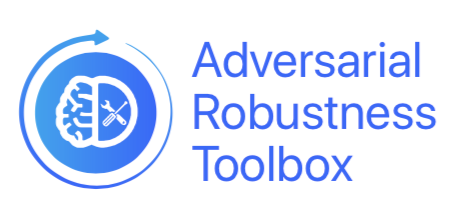

We will be using the Adversarial Robustness Toolbox (ART) python library.

Documentation for ART is [here](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/).

We will be doing a simple kind of attack in this notebook. There are many more listed in the documentation for ART you can try out!

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier

C:\Users\Y\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, we will begin by creating functions to define a Simple CNN model and load the MNIST dataset:

In [3]:
# Define the SimpleCNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv1(x), 2))
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

# Load MNIST dataset
def load_mnist():
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    return trainset, testset

Next, we will provide functions to:
1. Load pre-trained model
2. Generate adversarial examples
3. Visualize adversarial examples
4. Naive defense (add gaussian smoothing)
5. Test defenses
6. Run

## How are we generating adversarial examples?

A process called FGM (Fast Gradient Method) - a generalized version of FGSM.

Unlike FGSM, which only uses the sign of the gradient, FGM uses the actual gradient values. The perturbation is applied directly proportional to the gradient.

Equation:

𝑥′=𝑥+𝜖⋅▽𝑥𝐽(𝜃,𝑥,𝑦)

FGM are more precise than FGSM, but are more complex and take more time to run.

In [4]:
# Load the pre-trained model
def load_model(path):
    model = SimpleCNN()
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    return model

# Generate adversarial examples
def generate_adversarial_examples(model, testset, epsilon=0.3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    classifier = PyTorchClassifier(
        model=model,
        loss=nn.CrossEntropyLoss(),
        input_shape=(1, 28, 28),
        nb_classes=10,
        device_type=device.type
    )
    attack = FastGradientMethod(estimator=classifier, eps=epsilon)

    # Select a subset of test images
    dataloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=True)
    images, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)

    adversarial_images = attack.generate(x=images.cpu().numpy())

    return images.cpu(), adversarial_images, labels.cpu()

# Visualize original and adversarial images
def visualize_adversarial_examples(original_images, adversarial_images, labels, predictions):
    plt.figure(figsize=(20, 4))
    for i in range(10):
        plt.subplot(2, 10, i+1)
        plt.imshow(original_images[i].squeeze(), cmap='gray')
        plt.title(f"Orig: {labels[i]}")
        plt.axis('off')

        plt.subplot(2, 10, i+11)
        plt.imshow(adversarial_images[i].squeeze(), cmap='gray')
        plt.title(f"Adv: {predictions[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Defense strategy: Gaussian smoothing
def preprocess_input(x, sigma=0.5):
    return torch.clamp(x + torch.randn_like(x) * sigma, 0, 1)

# Test multiple defenses
def test_defenses(model, original_images, adversarial_images, true_labels, defense=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    def get_accuracy(images):
        with torch.no_grad():
            outputs = model(images.to(device))
            _, predictions = outputs.max(1)
            return (predictions.cpu() == true_labels).float().mean().item()

    # Original accuracy
    orig_accuracy = get_accuracy(original_images)

    # Adversarial accuracy (no defense)
    adv_images_torch = torch.from_numpy(adversarial_images).float()
    adv_accuracy = get_accuracy(adv_images_torch)

    print(f"Original accuracy: {orig_accuracy:.4f}")
    print(f"Adversarial accuracy: {adv_accuracy:.4f}")


    # Defense 1: Gaussian smoothing
    defended_images_1 = preprocess_input(adv_images_torch, sigma=0.5)
    defended_accuracy_1 = get_accuracy(defended_images_1)

    # Defense 2: Stronger Gaussian smoothing
    defended_images_2 = preprocess_input(adv_images_torch, sigma=1.0)
    defended_accuracy_2 = get_accuracy(defended_images_2)

    if defense==True:
      print(f"Defended accuracy (Gaussian sigma=0.5): {defended_accuracy_1:.4f}")
      print(f"Defended accuracy (Gaussian sigma=1.0): {defended_accuracy_2:.4f}")

    return adv_images_torch, defended_images_1, defended_images_2

# Main function to run the activity
def run_adversarial_activity(model_path, defense=False):
    # Load pre-trained model
    model = load_model(model_path)
    model.eval()

    # Load data
    _, testset = load_mnist()

    # Generate adversarial examples
    original_images, adversarial_images, true_labels = generate_adversarial_examples(model, testset, epsilon=0.3)

    # Test defenses and get processed images
    adv_images, def_images_1, def_images_2 = test_defenses(model, original_images, adversarial_images, true_labels, defense)

    # Visualize results
    visualize_adversarial_examples(original_images, adv_images, true_labels, model(adv_images).argmax(1))
    if defense==True:
      visualize_adversarial_examples(original_images, def_images_1, true_labels, model(def_images_1).argmax(1))
      visualize_adversarial_examples(original_images, def_images_2, true_labels, model(def_images_2).argmax(1))

# Base Model on Adversarial Images

The base model is a simple CNN trained on the MNIST data.


C:\Users\Y\AppData\Local\Temp\ipykernel_33860\4132367909.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=torch.device

Original accuracy: 1.0000
Adversarial accuracy: 0.0000


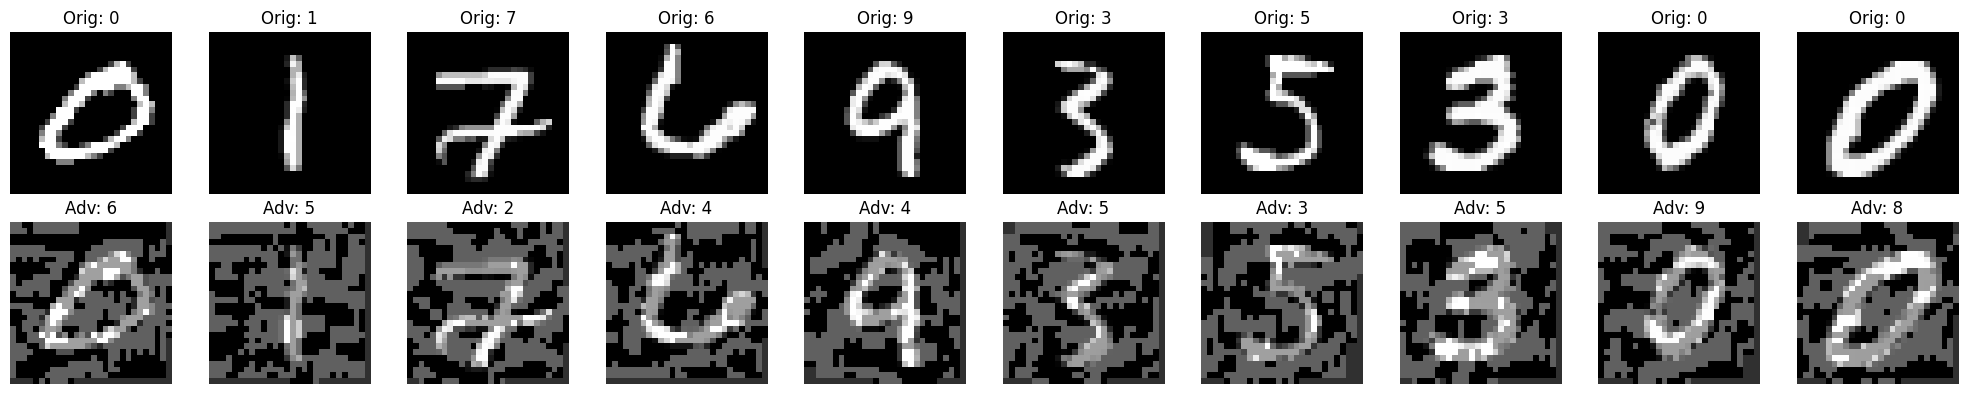

In [16]:
base_model = 'models/mnist_cnn.pth'
run_adversarial_activity(base_model)

# Base Model on Adversarial Images with Naive Defense Strategy

The naive adversarial defense strategy is Gaussian smoothing. Gaussian smoothing adds random noise to the input, which can disrupt small, carefully crafted adversarial perturbations.

C:\Users\Y\AppData\Local\Temp\ipykernel_33860\4132367909.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=torch.device

Original accuracy: 1.0000
Adversarial accuracy: 0.0000
Defended accuracy (Gaussian sigma=0.5): 0.0000
Defended accuracy (Gaussian sigma=1.0): 0.1000


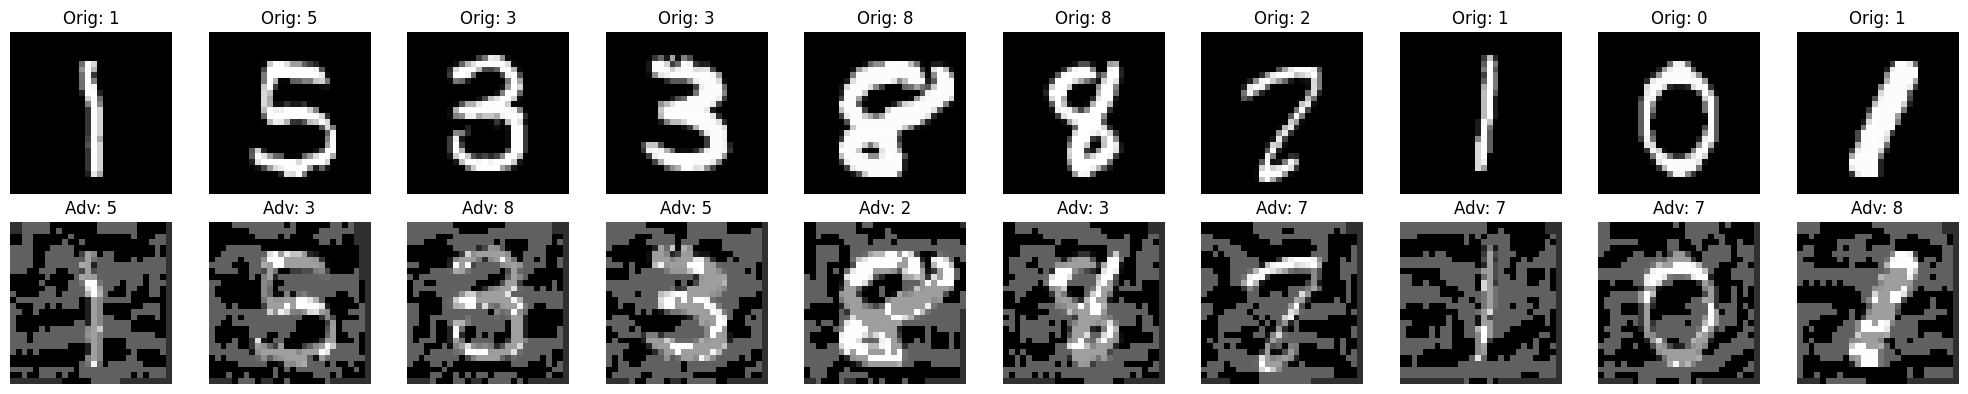

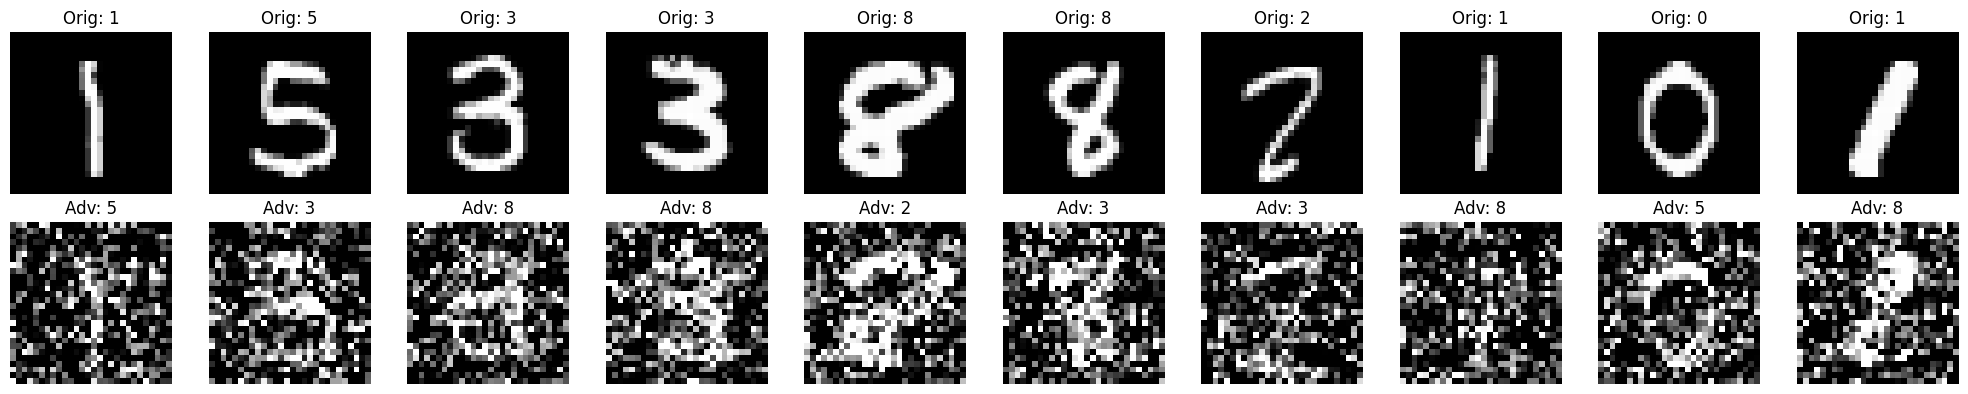

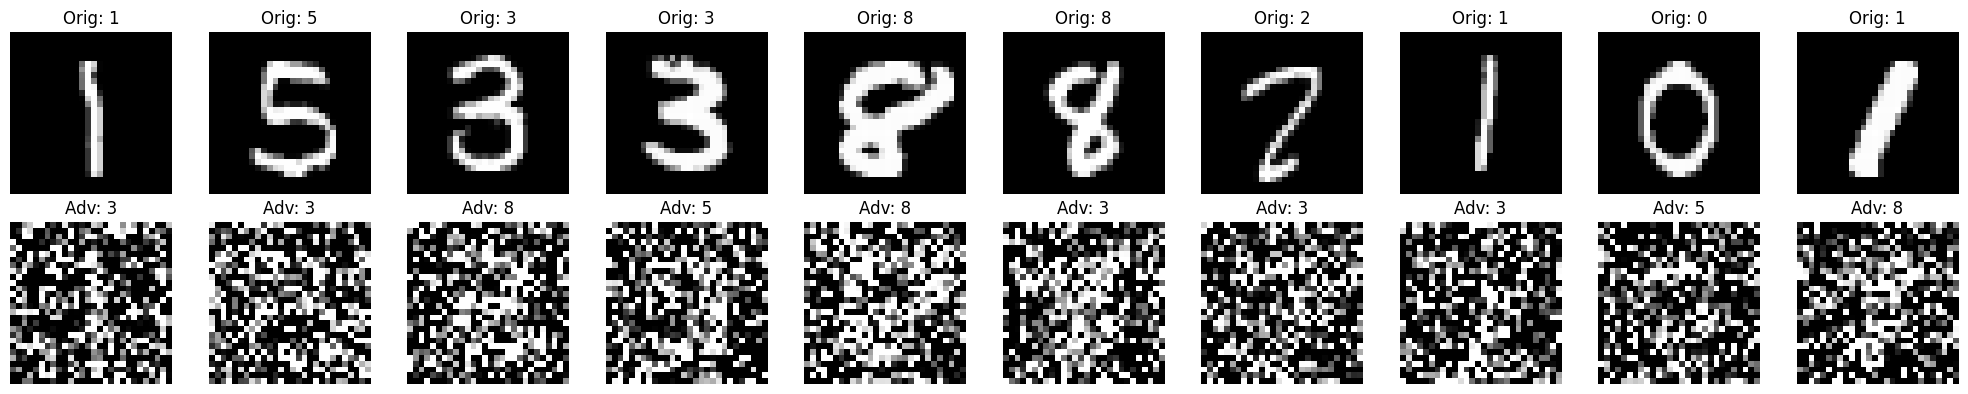

In [17]:
run_adversarial_activity(base_model, defense=True)

# Model re-trained using adversarial examples

We can generate adversarial images and re-train our model using both the original images and the adversarial images.

C:\Users\Y\AppData\Local\Temp\ipykernel_33860\4132367909.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=torch.device

Original accuracy: 1.0000
Adversarial accuracy: 0.9000


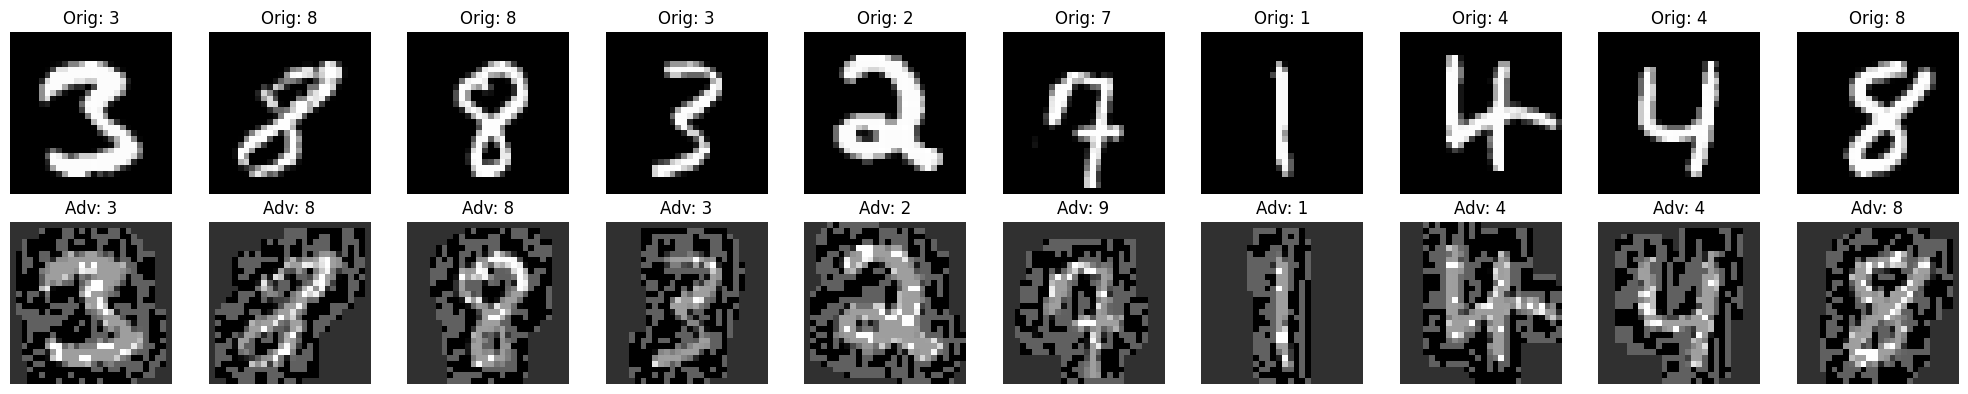

In [18]:
model_trained_adversarial_examples = 'models/mnist_cnn_adversarial.pth'
run_adversarial_activity(model_trained_adversarial_examples)

C:\Users\Y\AppData\Local\Temp\ipykernel_33860\4132367909.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=torch.device

Original accuracy: 1.0000
Adversarial accuracy: 1.0000


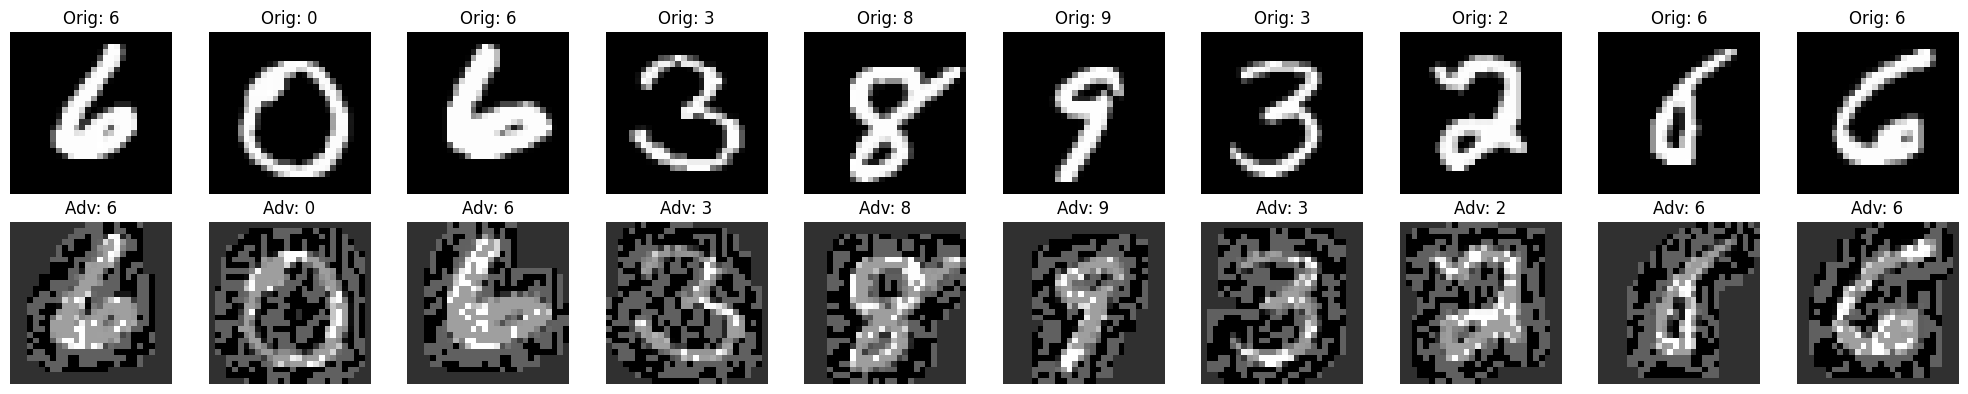

In [21]:
model_trained_adversarial_examples = 'models/mnist_cnn_adversarial.pth'
run_adversarial_activity(model_trained_adversarial_examples)

# Code for Training Models

### Base Model

In [8]:
def train_model(model, trainset, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

    print(f"Training on {device}")
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(trainloader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % 100 == 99:    # print every 100 mini-batches
                print(f'Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {running_loss / 100:.3f}')
                running_loss = 0.0
        print(f'Epoch {epoch + 1}/{epochs} completed')

    print("Finished Training")
    torch.save(model.state_dict(), 'mnist_cnn.pth')
    print("Model saved as 'mnist_cnn.pth'")

In [9]:
model = SimpleCNN()
trainset, _ = load_mnist()
train_model(model, trainset)

Training on cpu
Epoch 1, Batch 100, Loss: 1.138
Epoch 1, Batch 200, Loss: 0.355
Epoch 1, Batch 300, Loss: 0.253
Epoch 1, Batch 400, Loss: 0.191
Epoch 1, Batch 500, Loss: 0.152
Epoch 1, Batch 600, Loss: 0.138
Epoch 1, Batch 700, Loss: 0.125
Epoch 1, Batch 800, Loss: 0.109
Epoch 1, Batch 900, Loss: 0.112
Epoch 1/5 completed
Epoch 2, Batch 100, Loss: 0.078
Epoch 2, Batch 200, Loss: 0.083
Epoch 2, Batch 300, Loss: 0.081
Epoch 2, Batch 400, Loss: 0.078
Epoch 2, Batch 500, Loss: 0.072
Epoch 2, Batch 600, Loss: 0.079
Epoch 2, Batch 700, Loss: 0.066
Epoch 2, Batch 800, Loss: 0.074
Epoch 2, Batch 900, Loss: 0.081
Epoch 2/5 completed
Epoch 3, Batch 100, Loss: 0.063
Epoch 3, Batch 200, Loss: 0.050
Epoch 3, Batch 300, Loss: 0.065
Epoch 3, Batch 400, Loss: 0.058
Epoch 3, Batch 500, Loss: 0.057
Epoch 3, Batch 600, Loss: 0.059
Epoch 3, Batch 700, Loss: 0.049
Epoch 3, Batch 800, Loss: 0.050
Epoch 3, Batch 900, Loss: 0.049
Epoch 3/5 completed
Epoch 4, Batch 100, Loss: 0.050
Epoch 4, Batch 200, Loss: 0.

### Model trained with adversarial examples

In [19]:
def train_adversarial_model(model, trainset, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

    classifier = PyTorchClassifier(
        model=model,
        loss=criterion,
        optimizer=optimizer,
        input_shape=(1, 28, 28),
        nb_classes=10,
        device_type=device.type
    )
    attack = FastGradientMethod(estimator=classifier, eps=0.3)

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(trainloader):
            data, target = data.to(device), target.to(device)

            # Generate adversarial examples
            adv_data = torch.from_numpy(attack.generate(x=data.cpu().numpy())).float().to(device)

            # Combine clean and adversarial examples
            combined_data = torch.cat((data, adv_data), 0)
            combined_target = torch.cat((target, target), 0)

            # Train on combined data
            optimizer.zero_grad()
            output = model(combined_data)
            loss = criterion(output, combined_target)
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}/{epochs} completed')

    torch.save(model.state_dict(), 'mnist_cnn_adversarial.pth')

In [20]:
model = SimpleCNN()
trainset, _ = load_mnist()
train_adversarial_model(model, trainset)

Epoch 1/20 completed
Epoch 2/20 completed
Epoch 3/20 completed
Epoch 4/20 completed
Epoch 5/20 completed
Epoch 6/20 completed
Epoch 7/20 completed
Epoch 8/20 completed
Epoch 9/20 completed
Epoch 10/20 completed
Epoch 11/20 completed
Epoch 12/20 completed
Epoch 13/20 completed
Epoch 14/20 completed
Epoch 15/20 completed
Epoch 16/20 completed
Epoch 17/20 completed
Epoch 18/20 completed
Epoch 19/20 completed
Epoch 20/20 completed


In [ ]:
model_trained_adversarial_examples = 'models/mnist_cnn_adversarial.pth'
run_adversarial_activity(model_trained_adversarial_examples)